# Online Retail
## Author: Erdem Tosun

### ======================================
### 1. Installing Required Libraries
### ======================================


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

### ======================================
### 2. Data Preprocessing
### ======================================


In [18]:
df = pd.read_csv("online_retail.csv", encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [19]:
# Remove null customerID
df = df[df['CustomerID'].notna()]

# Remove 0 or negative sales
df = df[df['Quantity'] > 0]

# Invoice Date to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate Total Price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### ======================================
### 3. Feature Engineering
### ======================================


In [21]:
# Reference Date
ref_date = df['InvoiceDate'].max()

# calc. RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                              # Frequency
    'TotalPrice': 'sum'                                  # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

rfm = rfm[rfm['Monetary'] > 0]
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


### ======================================
### 4. Model Settings and Evaluation
### ======================================


In [22]:
from sklearn.preprocessing import StandardScaler

# Copy RFM, secure original
rfm_scaled = rfm.copy()

# Scale
scaler = StandardScaler()
rfm_scaled[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm_scaled[['Recency', 'Frequency', 'Monetary']])

In [23]:
# Train K means (4cluster)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_scaled['Segment'] = kmeans.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])

# Merge segments with original rfm
rfm_final = rfm.copy()
rfm_final['Segment'] = rfm_scaled['Segment']
rfm_final.head()

,Recency,Frequency,Monetary,Segment
CustomerID,,,,
12346.0,325,1,77183.60,0
12347.0,1,7,4310.00,3
12348.0,74,4,1797.24,3
12349.0,18,1,1757.55,3
12350.0,309,1,334.40,1


In [24]:
# RFM Averages of Segments
segment_summary = rfm_final.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Segment': 'count'
}).rename(columns={'Segment': 'Count'})

segment_summary

,Recency,Frequency,Monetary,Count
Segment,,,,
0,14.672986,22.047393,12453.225924,211
1,247.564030,1.551789,478.107581,1062
2,6.384615,82.692308,127338.313846,13
3,42.920380,3.656619,1350.140532,3052


### ======================================
### 5. Visualizing
### ======================================


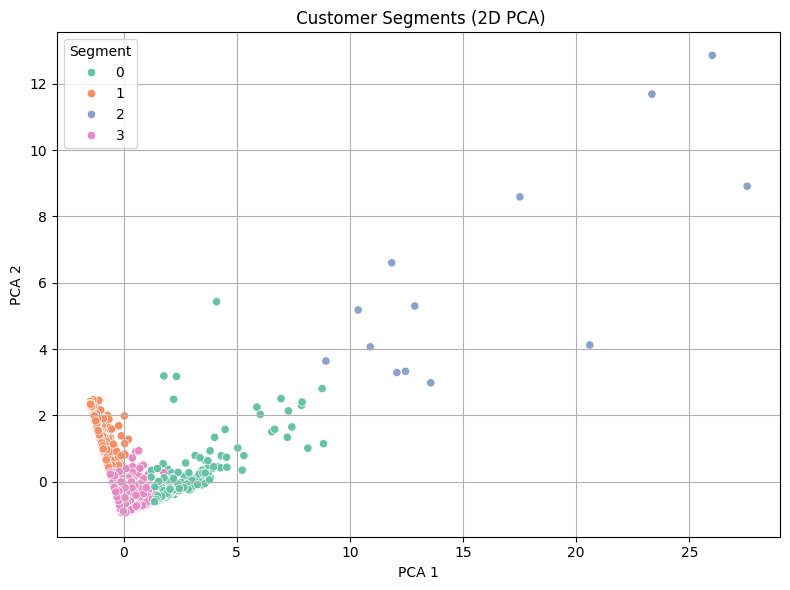

In [26]:
# Dimension Reduction with PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled[['Recency', 'Frequency', 'Monetary']])

# Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm_scaled['Segment'], palette='Set2')
plt.title(" Customer Segments (2D PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

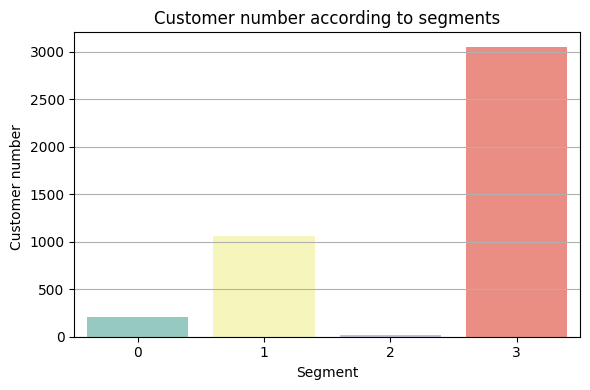

In [27]:
# Customer Distrubition
plt.figure(figsize=(6, 4))
sns.countplot(data=rfm_final, x='Segment', palette='Set3')
plt.title("Customer number according to segments")
plt.xlabel("Segment")
plt.ylabel("Customer number ")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

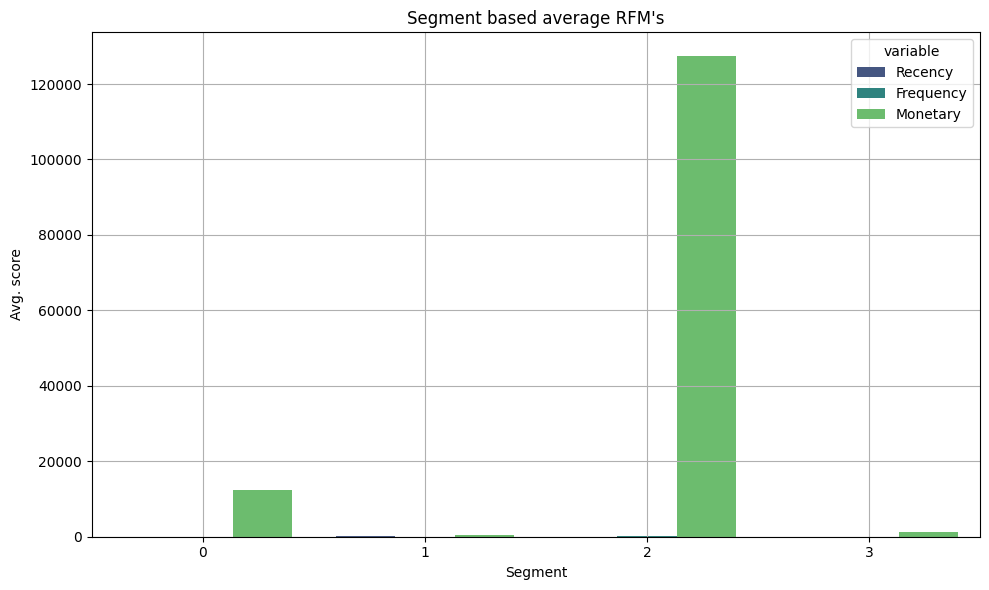

In [28]:
#Long format
rfm_melted = rfm_final.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().reset_index().melt(id_vars='Segment')

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=rfm_melted, x='Segment', y='value', hue='variable', palette='viridis')
plt.title("Segment based average RFM's")
plt.ylabel("Avg. score")
plt.grid(True)
plt.tight_layout()
plt.show()


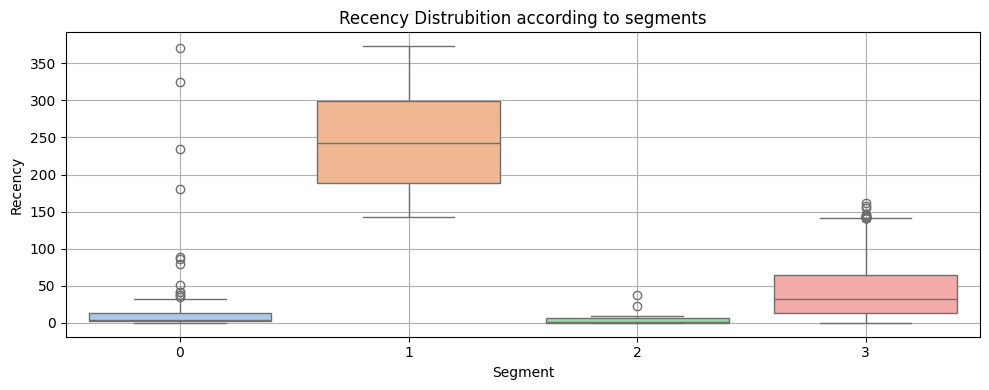

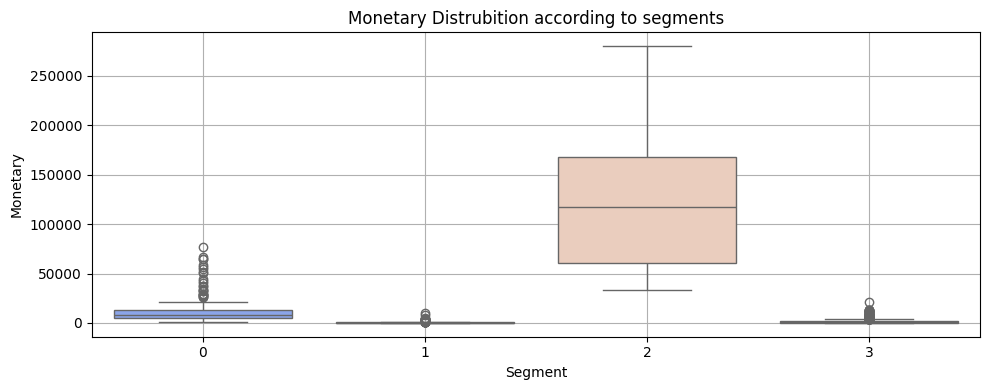

In [29]:
# Recency Boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(data=rfm_final, x='Segment', y='Recency', palette='pastel')
plt.title("Recency Distrubition according to segments")
plt.grid(True)
plt.tight_layout()
plt.show()

# Monetary Boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(data=rfm_final, x='Segment', y='Monetary', palette='coolwarm')
plt.title("Monetary Distrubition according to segments")
plt.grid(True)
plt.tight_layout()
plt.show()


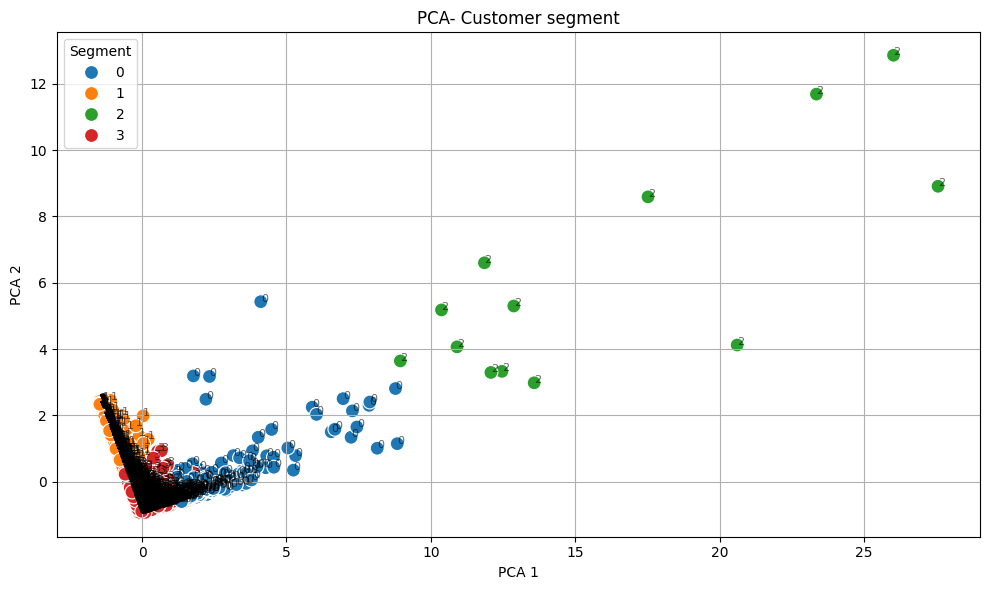

In [30]:
# Labeled Scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm_scaled['Segment'], palette='tab10', s=100)
for i, txt in enumerate(rfm_scaled['Segment']):
    plt.text(rfm_pca[i, 0], rfm_pca[i, 1], str(txt), fontsize=8, alpha=0.6)
plt.title("PCA- Customer segment")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


### ======================================
### 6. Model Saving
### ======================================


In [31]:
import joblib

# Save
joblib.dump(kmeans, "models/customer_segmentation_kmeans.pkl")
print("KMeans model saved: models/customer_segmentation_kmeans.pkl")

KMeans model saved: models/customer_segmentation_kmeans.pkl
